Predictive Maintenance:
- Objective: Use historical maintenance data to predict when an asset is likely to fail or require maintenance.
- Approach: Train a machine learning model on your work order data (including features like asset age, frequency of previous work orders, and spare parts usage) to predict future failures or maintenance needs.
- Outcome: This helps you shift from reactive or preventive maintenance to predictive maintenance, reducing downtime and optimizing maintenance schedules.

Natural Language Processing (NLP) for Work Order Descriptions:
- Objective: Analyze textual descriptions of work orders to extract useful insights.
- Approach: Use NLP techniques to categorize and analyze work order descriptions, identifying common issues, sentiments, or recurring themes.
- Outcome: Better understanding of the types of problems being reported and the ability to address systemic issues more effectively.

Anomaly Detection:
- Objective: Automatically detect unusual patterns or anomalies in maintenance data that could indicate potential issues.
- Approach: Implement anomaly detection algorithms (e.g., isolation forests, autoencoders) on sensor data, work order timing, or cost data to identify when an asset is behaving abnormally.
- Outcome: Early detection of potential problems before they lead to significant failures, improving asset reliability.

Cost Optimization:
- Objective: Optimize the maintenance budget by identifying cost-saving opportunities.
- Approach: Use AI algorithms to analyze historical cost data and identify patterns, such as which preventive maintenance actions are most effective at reducing corrective maintenance costs.
- Outcome: More efficient allocation of resources, reducing unnecessary expenditures while maintaining asset performance.

Failure Mode Prediction:
- Objective: Predict specific failure modes or issues based on patterns in the maintenance data.
- Approach: Use classification algorithms (e.g., decision trees, random forests) to predict the likelihood of different types of failures (e.g., electrical vs. mechanical) based on historical maintenance records and sensor data.
- Outcome: Tailored maintenance strategies that address the most likely failure modes for each asset.

Automated Reporting and Insights:
- Objective: Automatically generate insights and reports from maintenance data.
- Approach: Develop AI models to analyze trends and generate summary reports that highlight key metrics, such as cost over time, asset performance, and maintenance efficiency.
- Outcome: Reduced manual effort in generating reports, with more consistent and actionable insights.


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Or use a regressor depending on your target variable
from sklearn.metrics import accuracy_score, mean_absolute_error

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns

# Load datasets
work_order_cm_df = pd.read_excel('Work_Order_CM.xlsx')
work_order_pm_df = pd.read_excel('Work_Order_PM.xlsx')
spare_issued_cm_df = pd.read_excel('Spare_Issued_CM.xlsx')
spare_issued_pm_df = pd.read_excel('Spare_Issued_PM.xlsx')
asset_list_df = pd.read_excel("./Asset List - Air Handling Unit.xlsx")

# Merge relevant datasets on Asset Number or Work Order Number for CM
merged_cm_df = pd.merge(work_order_cm_df, spare_issued_cm_df, left_on='Work Order', right_on='WORK ORDER NUMBER', how='left')
merged_cm_df = pd.merge(merged_cm_df, asset_list_df, left_on='Asset Number', right_on='ASSET NUMBER', how='left')

merged_cm_df["Work Order Type"] = "CM"

# Merge relevant datasets on Asset Number or Work Order Number for PM
merged_pm_df = pd.merge(work_order_cm_df, spare_issued_cm_df, left_on='Work Order', right_on='WORK ORDER NUMBER', how='left')
merged_pm_df = pd.merge(merged_pm_df, asset_list_df,  left_on='Asset Number', right_on='ASSET NUMBER', how='left')

merged_pm_df["Work Order Type"] = "PM"

# Concatenate the CM and PM data into a single DataFrame
combined_df = pd.concat([merged_cm_df, merged_pm_df])

combined_df.head()
combined_df.to_csv('combined_df.csv', index=False)

In [48]:
# Drop columns that are not needed
cleaned_combined_df = combined_df.drop(columns=['Assign', 'Asset Group', 'Description',
       'Target Time', 'Contractor', 'Parent Asset Group', 'Owning Department', 'Work Order Department', 'Life & Safety Asset', 'Resolution Code', 'Created By', 'Last updated by',
       'Update Work Order', 'Complete Work Order', 'Requestor Staff Id',
       'Requestor Name', 'QA Review Comments', 'Remarks', 'Mode of Reporting','MAJOR CATEGORY',
       'MINOR CATEGORY', 'WORK ORDER NUMBER', 'ASSET NUMBER_x',
       'ASSET GROUP_x', 'MAKE MODEL', 'CONTRACTOR', 'DEPARTMENT','ACTIVITY CODE'], inplace=False)

In [49]:
cleaned_combined_df.columns
cleaned_combined_df.to_csv('combined_df.csv', index=False)

In [50]:
cleaned_combined_df['ITEM NAME'] = cleaned_combined_df['ITEM NAME'].fillna('No Item Issued')
cleaned_combined_df['QUANTITY'] = cleaned_combined_df['QUANTITY'].fillna(0)
cleaned_combined_df['TOTAL VALUE'] = cleaned_combined_df['TOTAL VALUE'].fillna(0.0)
cleaned_combined_df['Creation Date & Time'] = pd.to_datetime(cleaned_combined_df['Creation Date & Time'])
cleaned_combined_df['Actual Response Date & Time'] = pd.to_datetime(cleaned_combined_df['Actual Response Date & Time'])
cleaned_combined_df['Actual Resolution Date & Time'] = pd.to_datetime(cleaned_combined_df['Actual Resolution Date & Time'])

In [105]:
# Create additional features
first_maintenance_date = cleaned_combined_df.groupby('Asset Number')['Creation Date & Time'].transform('min')
# Como no tenemos el tiempo del aire, ponemos la primera que tengamos
cleaned_combined_df['Asset Age'] = (cleaned_combined_df['Creation Date & Time'] - first_maintenance_date).dt.days
# cleaned_combined_df['Asset Age'] = (pd.to_datetime(cleaned_combined_df['Creation Date & Time']) - pd.to_datetime(cleaned_combined_df['INSTALLATION DATE'])).dt.days

cleaned_combined_df['Time Since Last Maintenance'] = cleaned_combined_df.groupby('Asset Number')['Creation Date & Time'].diff().dt.days
cleaned_combined_df['Total Spare Parts Cost'] = cleaned_combined_df.groupby('Asset Number')['TOTAL VALUE'].cumsum()
cleaned_combined_df['Failure Count'] = cleaned_combined_df.groupby('Asset Number').cumcount() + 1
cleaned_combined_df['Avg Time Between Maintenance'] = cleaned_combined_df.groupby('Asset Number')['Time Since Last Maintenance'].transform('mean')
cleaned_combined_df['Month'] = pd.to_datetime(cleaned_combined_df['Creation Date & Time']).dt.month

# Ordenar el DataFrame por número de activo y fecha de creación
cleaned_combined_df = cleaned_combined_df.sort_values(by=['Asset Number', 'Creation Date & Time'])

# Calcular el tiempo hasta el próximo fallo
cleaned_combined_df['Time to Next Failure'] = cleaned_combined_df.groupby('Asset Number')['Creation Date & Time'].shift(-1) - cleaned_combined_df['Creation Date & Time']
cleaned_combined_df['Time to Next Failure'] = cleaned_combined_df['Time to Next Failure'].dt.days

cleaned_combined_df = cleaned_combined_df.dropna(subset=['Time to Next Failure'])
cleaned_combined_df_head = cleaned_combined_df.head()

# # Eliminar filas donde el tiempo hasta el próximo fallo es NaN (última entrada para cada activo)
# cleaned_combined_df = cleaned_combined_df.fillna(method='ffill')  # Example of forward fill

# import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Combined DataFrame", dataframe=cleaned_combined_df)
cleaned_combined_df['Failure Code'] = cleaned_combined_df['Failure Code'].fillna('UNDEFINED')
cleaned_combined_df['Total Spare Parts Cost'] = cleaned_combined_df['Total Spare Parts Cost'].fillna(0.0)



In [106]:
# Create binary target variables for failure within 1 month and 3 months
cleaned_combined_df['Failure_1_Month'] = (cleaned_combined_df['Time to Next Failure'] <= 30).astype(int)
cleaned_combined_df['Failure_3_Months'] = (cleaned_combined_df['Time to Next Failure'] <= 90).astype(int)

In [107]:
cleaned_combined_df.to_csv('combined_df_dataset.csv', index=False)

In [108]:
from sklearn.model_selection import train_test_split

# Example for 1-month failure prediction
X = cleaned_combined_df[['Asset Age', 'Time Since Last Maintenance', 'Total Spare Parts Cost', 'Failure Count', 'Avg Time Between Maintenance', 'Month']]
y_f = cleaned_combined_df['Time to Next Failure']
y_cost = cleaned_combined_df['Total Spare Parts Cost']
y_failure_type = cleaned_combined_df['Failure Code']

from sklearn.preprocessing import LabelEncoder
# Encode the Failure Code labels as numbers
label_encoder = LabelEncoder()
y_failure_type_encoded = label_encoder.fit_transform(cleaned_combined_df['Failure Code'])

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y_f, test_size=0.3, random_state=42)
X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X, y_cost, test_size=0.3, random_state=42)
X_train_failure_type, X_test_failure_type, y_train_failure_type, y_test_failure_type = train_test_split(
    X, y_failure_type_encoded, test_size=0.3, random_state=42)

In [109]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar un modelo de regresión
model_f = RandomForestRegressor(n_estimators=100, random_state=42)
model_f.fit(X_train_f, y_train_f)

RandomForestRegressor(random_state=42)

In [110]:
from sklearn.ensemble import RandomForestRegressor

model_cost = RandomForestRegressor(n_estimators=100, random_state=42)
model_cost.fit(X_train_cost, y_train_cost)

RandomForestRegressor(random_state=42)

In [111]:
model_failure_type = RandomForestClassifier(n_estimators=100, random_state=42)
model_failure_type.fit(X_train_failure_type, y_train_failure_type)

RandomForestClassifier(random_state=42)

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Hacer predicciones en el conjunto de prueba
y_pred_f = model_f.predict(X_test_f)

# Evaluar el modelo
mse = mean_squared_error(y_test_f, y_pred_f)
r2 = r2_score(y_test_f, y_pred_f)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Repeat similar steps for the cost prediction
y_pred_cost = model_cost.predict(X_test_cost)
# Evaluate the model using regression metrics
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
mae_cost = mean_absolute_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

print(f"Cost Prediction: \nMSE: {mse_cost}\nMAE: {mae_cost}\nR^2: {r2_cost}")
print()

# Repeat similar steps for the failure type prediction
y_pred_failure_type = model_failure_type.predict(X_test_failure_type)

# Evaluate the model
accuracy = accuracy_score(y_test_failure_type, y_pred_failure_type)
precision = precision_score(y_test_failure_type, y_pred_failure_type, average='weighted', zero_division=0)
recall = recall_score(y_test_failure_type, y_pred_failure_type, average='weighted', zero_division=0)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(y_test_failure_type, y_pred_failure_type)
classification_rep = classification_report(y_test_failure_type, y_pred_failure_type, target_names=label_encoder.classes_, zero_division=0)

print(f"Failure Type Prediction: \nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Mean Squared Error: 507.8438109933158
R^2 Score: 0.1778537047032338
Cost Prediction: 
MSE: 2513.3664203994886
MAE: 7.088043282931326
R^2: 0.9999943686336794

Failure Type Prediction: 
Accuracy: 0.7832566294104756
Precision: 0.7850095435093967
Recall: 0.7832566294104756
F1 Score: 0.778130619662473
Confusion Matrix:
 [[   0    0    1    0    0    0    0    0    0    0    1    0    0    0
     0]
 [   0   37    7   17    0    0    0    0    0    0    0    0    0    7
     0]
 [   2    0  925  175    5    1    0    0    0   10   46    0    0   20
     1]
 [   1    1  150 1420    1    0    0    0    0    8   38    0    0   17
     0]
 [   0    0   36   24   21    0    0    0    0    0    5    0    0    3
     0]
 [   0    0    3    5    0    0    0    0    0    0    1    0    0    1
     0]
 [   0    0    1    2    0    0    2    0    0    0    1    0    0    0
     0]
 [   0    0    0    1    0    0    0    0    0    0    4    0    0    0
     0]
 [   0    0    1    4    0    0    0    0  

In [113]:
import joblib

joblib.dump(model_f, 'model_f.pkl')
# Guardar los modelos entrenados
joblib.dump(model_failure_type, 'model_failure_type.pkl')
joblib.dump(model_cost, 'model_cost.pkl')

['model_cost.pkl']

In [ ]:
tipo, coste, cuanto en romperse, a 1 mes y 3 meses


pasar maquina
listado total para tener tiempo de rotura y agrupar, tipo de averia, coste 
desgrosar piezas ?



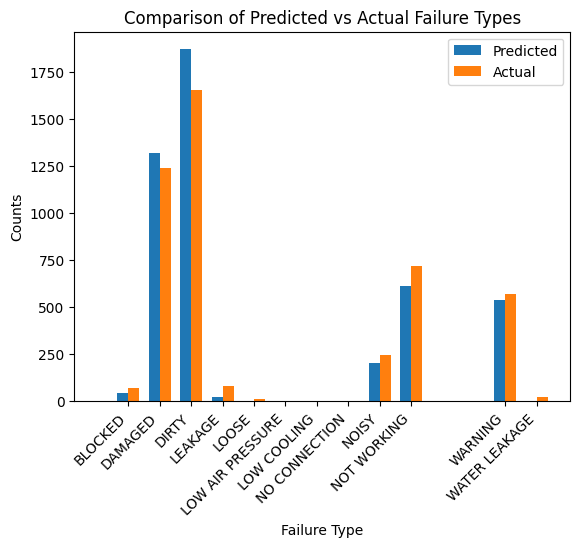

In [99]:
import numpy as np

# Contar predicciones por clase
unique_labels, counts = np.unique(y_pred_failure_type, return_counts=True)
unique_labels_true, counts_true = np.unique(y_test_failure_type, return_counts=True)

# Gráfico de barras
fig, ax = plt.subplots()
width = 0.35  # Ancho de las barras

# Barras de predicciones
ax.bar(unique_labels - width/2, counts, width, label='Predicted')

# Barras de valores reales
ax.bar(unique_labels_true + width/2, counts_true, width, label='Actual')

ax.set_xlabel('Failure Type')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Predicted vs Actual Failure Types')
ax.set_xticks(unique_labels)
ax.set_xticklabels(label_encoder.inverse_transform(unique_labels), rotation=45, ha="right")
ax.legend()

plt.show()

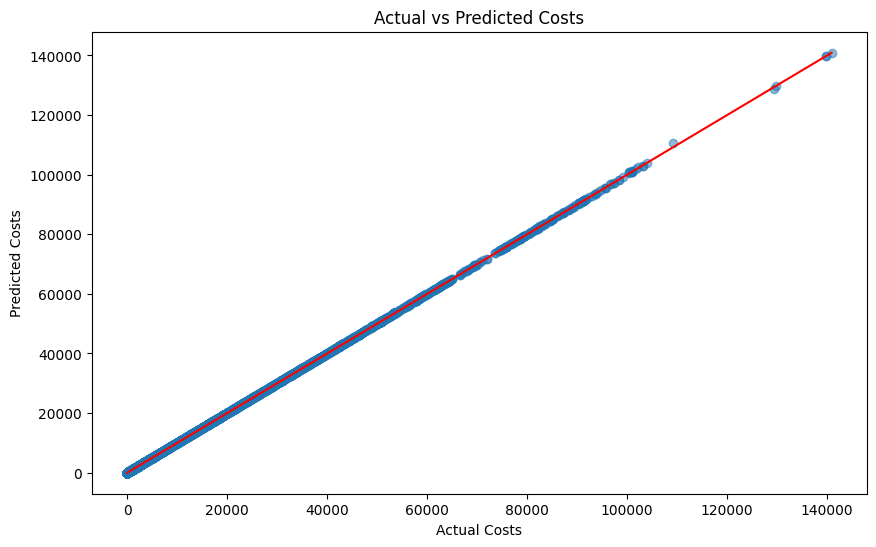

In [100]:
# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test_cost, y_pred_cost, alpha=0.5)
plt.plot([min(y_test_cost), max(y_test_cost)], [min(y_test_cost), max(y_test_cost)], color='red')  # Línea de referencia
plt.xlabel("Actual Costs")
plt.ylabel("Predicted Costs")
plt.title("Actual vs Predicted Costs")
plt.show()